In [1]:
%matplotlib inline

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt

CDI = 14.15

from utils import compute_features
from gym_env import EpisodeProvider, ExitTrainingEnv
from features import compute_bt_indicators

In [2]:
tickers = ['^BVSP']

start_date = '2013-11-01'
end_date =  '2023-11-01'


In [3]:

for ticker in tickers:
    prices = yf.download(ticker, start=start_date, end=end_date, interval='1d', auto_adjust=True)
    data = prices.droplevel(1, axis=1)
    df = data.dropna()

    # Salvando o CSV
    df.iloc[:-252,:].to_csv('{}-train.csv'.format(ticker))
    df.iloc[-252:,:].to_csv('{}-back.csv'.format(ticker))

[*********************100%***********************]  1 of 1 completed


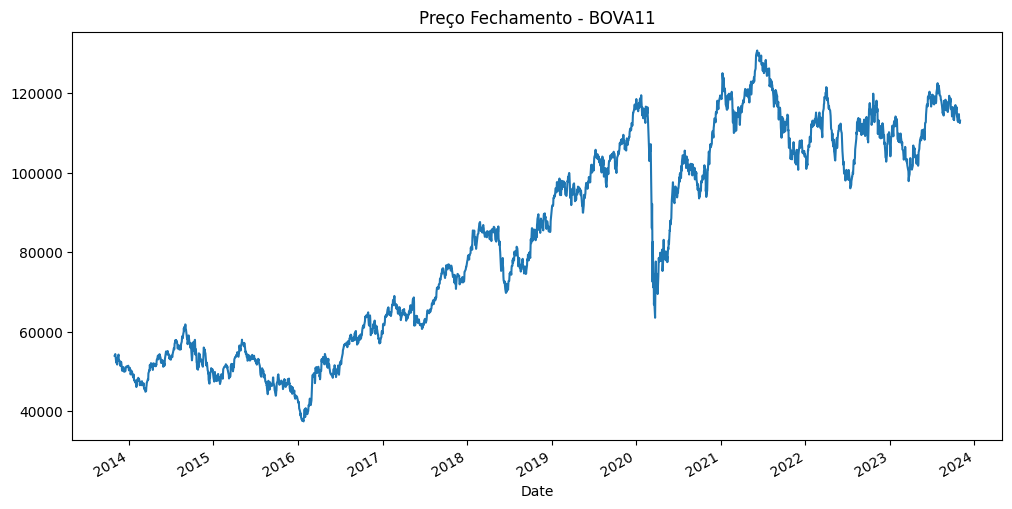

In [4]:
df.Close.plot(title='Preço Fechamento - BOVA11', figsize=(12,6));

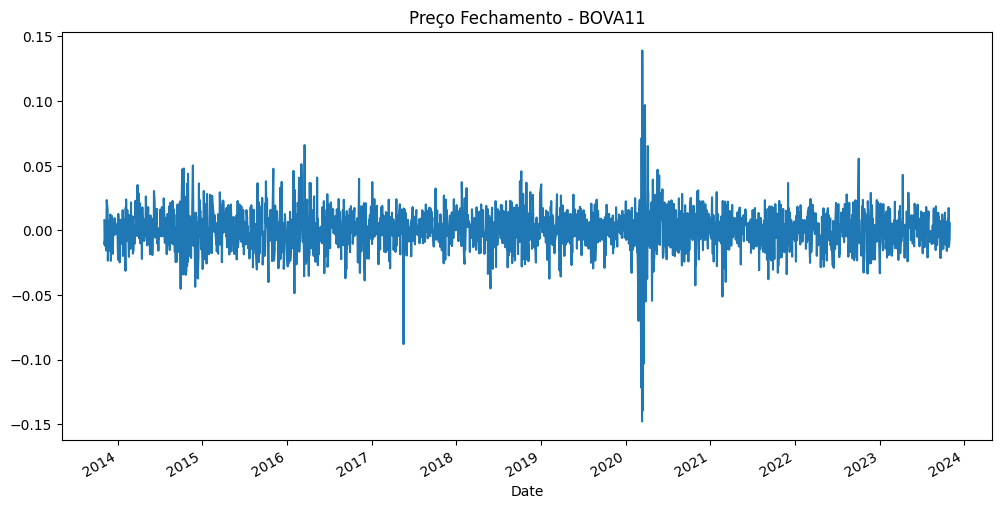

In [5]:
df.Close.pct_change().dropna().plot(title='Preço Fechamento - BOVA11', figsize=(12,6))
plt.show()

In [3]:
df = pd.DataFrame()
df = pd.read_csv(f'{tickers[0]}-train.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2013-11-01,54013.0,54387.0,53753.0,54255.0,4094400
2013-11-04,54437.0,54531.0,54008.0,54014.0,2731000
2013-11-05,53832.0,54539.0,53731.0,54436.0,3327700
2013-11-06,53385.0,53857.0,53073.0,53840.0,4258800
2013-11-07,52741.0,53891.0,52558.0,53390.0,4874300


In [4]:
df_ind = compute_bt_indicators(df)   # backtrader-calculated indicators
df = df.join(df_ind, how="inner")    # merge into main df
df = df.fillna(method="bfill").fillna(method="ffill")
df.head()

/tmp/ipykernel_67124/1844689510.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")


,Close,High,Low,Open,Volume,rsi,roc,volatility,macd_hist,atr,ma,ema,bb_perc
2013-12-20,51186.0,51641.0,51025.0,51620.0,3715200,47.123291,-0.001151,410.925337,202.023230,764.551130,50545.285714,50821.209684,0.889800
2013-12-23,51356.0,51605.0,51188.0,51188.0,2305800,48.692864,0.020000,455.939560,241.028926,739.868906,50617.214286,50892.515059,0.905090
2013-12-26,51221.0,51610.0,51185.0,51358.0,1810000,47.487371,0.020014,466.121689,251.805819,717.378270,50689.000000,50936.313051,0.785333
2013-12-27,51267.0,51395.0,51207.0,51239.0,2002600,47.960135,0.009431,489.144031,255.301583,679.565537,50723.214286,50980.404645,0.777927
2013-12-30,51507.0,51996.0,51274.0,51274.0,2048600,50.465803,0.011051,527.297654,265.849166,683.096570,50763.428571,51050.617359,0.852539


In [8]:
entries = df.index[df["rsi"] < 30].tolist()
entries = df.index.get_indexer(entries)

print(entries)

[  27  191  243  244  390  391  392  407  409  410  411  412  413  502
  503  504  505  506  507  508  509  510  511  512  513  514 1094 1095
 1101 1102 1103 1104 1105 1106 1107 1108 1525 1526 1532 1533 1535 1536
 1538 1540 1541 1542 1543 1891 1913 2060 2063 2064 2065 2067 2068 2069
 2070 2094 2095 2097 2098 2099 2100 2101 2102]


In [6]:
provider = EpisodeProvider(
    df=df,
    entry_indices=entries,
    max_horizon=50,
    stop_loss=-0.05,
    take_profit=0.10,
    feature_function=compute_features
)

env = ExitTrainingEnv(provider)

In [7]:
obs = env.reset()
print("Initial observation:", obs)

for _ in range(10):
    obs, reward, done, truncated, info = env.step(env.action_space.sample())
    print(obs, reward, done)
    if done:
        obs = env.reset()

Initial observation: (array([ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  2.9014240e+01,
       -3.7098241e-01,  1.4175350e+04, -2.5582085e+03,  6.7021440e+03,
       -2.0412108e-01, -1.7949338e-01,  1.9663258e-01], dtype=float32), {})
[-5.2170154e-02  9.4782984e-01  1.0000000e+00  2.7387428e+01
 -3.9765200e-01  1.3793374e+04 -2.3734526e+03  6.6122051e+03
 -2.1781866e-01 -1.9854426e-01  1.7914459e-01] -0.4388316509862977 True
[ 0.0000000e+00  1.0000000e+00  0.0000000e+00  2.4439713e+01
 -1.1603291e-01  1.2942759e+03 -1.1161443e+02  9.1155389e+02
 -3.9314400e-02 -4.1903906e-02  2.0359875e-01] -0.3667493399471958 True
[ 0.0000000e+00  1.0000000e+00  0.0000000e+00  2.5967112e+01
 -1.0750560e-01  3.2483044e+03 -8.0651904e+02  2.2485444e+03
 -5.0088681e-02 -4.8164263e-02  8.0984682e-02] -0.08855205811138014 True
[-1.0408950e-03  9.9895912e-01  1.0000000e+00  2.7171349e+01
 -8.9138374e-02  3.6749666e+03 -1.0364467e+03  1.9616913e+03
 -4.6720777e-02 -4.0083457e-02  1.4482671e-01] 0.0 Fals

In [13]:
from stable_baselines3 import DQN
from stable_baselines3.common.logger import configure

# Optional: logging folder
logger = configure("./logs_dqn", ["stdout", "csv", "tensorboard"])

model = DQN(
    "MlpPolicy",
    env,
    learning_rate=1e-4,
    buffer_size=50_000,
    batch_size=32,
    learning_starts=1_000,
    gamma=0.99,
    tau=1.0,
    train_freq=1,
    gradient_steps=1,
    exploration_fraction=0.1,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    verbose=1,
    tensorboard_log="./logs_dqn/"
)

model.learn(total_timesteps=10_000)#300_000)
model.save("exit_rl_dqn")


Logging to ./logs_dqn
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs_dqn/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | -0.117   |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 228      |
|    time_elapsed     | 0        |
|    total_timesteps  | 4        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.25     |
|    ep_rew_mean      | -0.189   |
|    exploration_rate | 0.991    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 347      |
|    time_elapsed     | 0        |
|    total_timesteps  | 10       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mea

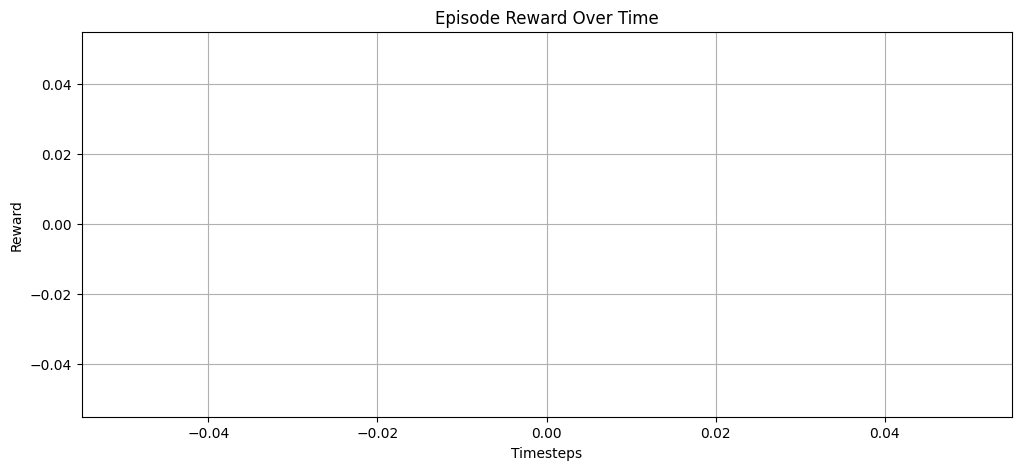

In [16]:
from tbparse import SummaryReader
import matplotlib.pyplot as plt

logdir = "./logs_dqn/DQN_1/"
reader = SummaryReader(logdir)

df = reader.scalars  # scalar data (reward, loss, etc.)
df_reward = df[df["tag"] == "rollout/ep_reward"]

plt.figure(figsize=(12,5))
plt.plot(df_reward["step"], df_reward["value"])
plt.title("Episode Reward Over Time")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

